# Computer Lab: nonnegative matrix factorization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import scipy.sparse
import scipy.sparse.linalg
from time import time

In [2]:
def build_matrix_from_faces(folder='orl_faces/', minidata=False):
    # load images
    # 400 images of size (112, 92)
    M = []
    if minidata is True:
        nb_subjects = 1
    else:
        nb_subjects = 40
    for subject in range(1, nb_subjects + 1
                        ):
        for image in range(1, 11):
            face = plt.imread(folder + '/s' + str(subject)
                              + '/' + str(image) + '.pgm')
            M.append(face.ravel())

    return np.array(M, dtype=float)

def vectorize(W, H):
    return np.concatenate((W.ravel(), H.ravel()))

def unvectorize_M(W_H, M):
    # number of elements in W_H is (n+p)*k where M is of size n x m
    # W has the nk first elements
    # H has the kp last elements
    n, p = M.shape
    k = W_H.shape[0] // (n + p)
    W = W_H[:n * k].reshape((n, k))
    H = W_H[n * k:].reshape((k, p))
    return W, H

Download the database at https://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html
Uncompress the file.

In [3]:
# Small data to test the algorithm
M = build_matrix_from_faces(folder='orl_faces/', minidata=True)
def unvectorize(W_H): return unvectorize_M(W_H, M)
k = 2

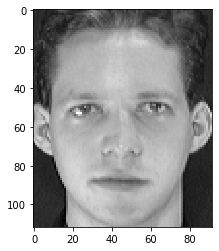

In [4]:
# To see the first face:
plt.imshow(M[0].reshape((112, 92)), cmap='gray'); plt.show()

## Question 2.1

In [5]:
# Full data
M = build_matrix_from_faces(folder='orl_faces/', minidata=False)
def unvectorize(W_H): return unvectorize_M(W_H, M)
k = 38

n,p = M.shape

print("There are " + str(n) + " images in the data set, each image with " + str (p) + " pixels.")

There are 400 images in the data set, each image with 10304 pixels.


## Question 3.1
Supposons $ n = p = 1 $ et posons $f(x,y) = \frac{1}{2} \cdot (M - x\cdot y)^2$.

La matrice hessienne associée à f est :

$$ H = \frac{1}{2} \cdot  \begin{pmatrix}
2y^2 & 4xy -2M\\
4xy -2M & 2x^2
\end{pmatrix} $$


Avec $ y = 1 $, le déterminant (multiplié par 4 pour enlever la fraction) de la matrice est :

$$ g(x) = -12x^2 -4M^2 + 16Mx $$

Or, $$g(x) \xrightarrow{x \xrightarrow{} \infty} -\infty < 0 $$
Nous avons donc qu'à partir d'un certain réel, le déterminant est strictement négatif, c'est à dire que les valeurs propres sont de signes opposées. Ainsi la matrice n'est pas positive et donc f n'est pas convexe.

## Question 3.2

Posons encore $$ f(W,H) =   \frac{1}{2np}  {{\left\|M - WH\right\|}_F}^2 = \frac{1}{2np} \cdot  tr((M -WH)\cdot {(M-WH)}^T) $$

Alors, $$ 2np\cdot f(W+w, H+h) = {{\left\|M - WH\right\|}_F}^2 -2<M-WH,wH+Wh> + {{\left\|wH - Wh\right\|}_F}^2 $$

En posant successivement $w=0$ et $h=0$, nous trouvons les gradients par rapport à $H$ puis à $W$.

D'où $grad(f(W,H)) =-\frac{1}{np}\cdot  \begin{pmatrix}
(M-WH)\cdot H^T\\W^T\cdot (M-WH)
  &
\end{pmatrix} $


## Question 4.1

In [6]:
W0, S, H0 = scipy.sparse.linalg.svds(M, k)

W0 = np.maximum(0, W0 * np.sqrt(S))
H0 = np.maximum(0,(H0.T * np.sqrt(S)).T)

On se rapproche d'un produit $WH = M$ en partant d'un cas où l'on est positivement sûr de cet égalité (à savoir $M = W_0SH_0$). 

On est sûr que $W_0$ et $H_0$ ont des coefficients positifs avec la fonction ``np.maximum``. On a donc une heuristique, qui espérons-le, permet de se rapprocher de la solution de manière plus rapide.

On aurait pu également choisir $W_0 = W_0 \cdot S$ et $H_0$ tel quel ou $H_0 = H_0 \cdot S$ avec $W_0$ tel quel.
On aurait pu de même choisir $W_0$ et $H_0$ de manière totalement arbitraire.

## Question 4.2

On a déjà que le gradient de  $g$ est ainsi (voir question 3.2):
 $grad(g(W)) =-\frac{1}{np}\cdot (M-WH)\cdot H^T $
 
D'où la matrice Hessienne est :
$$H_g = \frac{1}{np} \cdot {(HH^T)}^T =\frac{1}{np} \cdot HH^T $$
C'est bien une matrice positive donc $g$ est convexe.

In [7]:
def g(W):
    return np.trace(np.dot(M-W@H0, (M-W@H0).T))/(2*n*p)
#    return 1/(2*n*p)* np.linalg.norm(M-W@H0,'fro')**2

def grad_g(W):
    return (W.dot(H0)-M).dot(np.transpose(H0))/(n*p)

def g_unvec(W_unvec):
    return 1/(2*n*p)* np.linalg.norm(M.reshape(-1)-(W_unvec.reshape((n,k))@H0).reshape(-1))**2

def grad_g_unvec(W_unvec):
    return ((M -(W_unvec.reshape((n,k)))@H0)@H0.T).reshape(-1)/(-n*p)

## Question 4.3
Le résultat retourné pour scipy.optimize.check_grad(g_unvec, grad_g_unvec, np.ones((n.k)))
est 0.006656803752079777.
Ce résultat étant long à obtenir, nous commentons le code à faire. Le résultat étant proche de 0, on peut supposer que les deux fonctions codées soient bonnes.

In [8]:
#scipy.optimize.check_grad(g_unvec, grad_g_unvec, np.ones((n*k)))

## Question 4.4
Renommons $\gamma \iota \mathbb{R}_+$ en $func$.
Remarquons que $prox_{func
}(y) = argmin_{x \in \mathbb{R}}( func(x) + {{\left\|x - y\right\|}_2}^2 ) = argmin_{x \in \mathbb{R}_+}( func(x) + {{\left\|x - y\right\|}_2}^2 ) $, car $func$ est infini sur l'espace des réel négatifs.

Si $ y \geq 0 $, on a donc  $prox_{func
}(y) = argmin_{x \in \mathbb{R}_+}({{\left\|x - y\right\|}_2}^2 ) = y$ car ce minimum est atteint en 0 par y.

Si $ y \leq 0 $, $prox_{func
}(y) = argmin_{x \in \mathbb{R}_+}({{\left\|x - y\right\|}_2}^2 ) = 0$.

La fonction est donc bien la projection sur les réels positifs.

## Question 4.5

In [9]:
def prox(u):
    if u>=0:
        return u
    else:
        return 0
    
def projected_gradient_method(val_g, grad_g, W0, gamma, N):
    x = W0
    L = [val_g(W0)]
    for i in range(N):
        intermediaire = x-gamma*grad_g(x)

        x = np.array([[prox(i) for i in j] for j in intermediaire])
        L+=[val_g(x)]
    return x,L

In [11]:
lipschitz_cst = np.linalg.norm(H0.T@H0, 'fro')

y, L_lip = projected_gradient_method(g,grad_g,W0,1/lipschitz_cst,100)

y, L = projected_gradient_method(g,grad_g,W0,1,100)

print("Méthode avec gamma = 1/constante_de_lipschitz ("+ str(1/lipschitz_cst)+") :", L_lip)

print("\n")
print("Méthode avec gamma = 1 :", L)

Méthode avec gamma = 1/constante_de_lipschitz (3.4555429731728355e-06) : [867.6350229602607, 867.6348753266026, 867.63472769301, 867.6345800594828, 867.634432426021, 867.6342847926244, 867.6341371592933, 867.6339895260279, 867.6338418928275, 867.6336942596927, 867.6335466266231, 867.6333989936192, 867.6332513606806, 867.6331037278072, 867.6329560949994, 867.6328084622569, 867.6326608295799, 867.6325131969681, 867.6323655644219, 867.6322179319411, 867.6320702995256, 867.6319226671756, 867.631775034891, 867.6316274026716, 867.6314797705178, 867.6313321384295, 867.6311845064063, 867.6310368744487, 867.6308892425563, 867.6307416107295, 867.6305939789681, 867.6304463472719, 867.6302987156413, 867.630151084076, 867.6300034525761, 867.6298558211416, 867.6297081897727, 867.6295605584689, 867.6294129272306, 867.6292652960578, 867.6291176649505, 867.6289700339082, 867.6288224029315, 867.6286747720203, 867.6285271411745, 867.628379510394, 867.6282318796789, 867.6280842490293, 867.6279366184449, 8

Nous remarquons que la valeur du pas est très faible, ce qui donne un algorithme très lent à converger. En revanche, en montant $\gamma$ à 1, l'algorithme avance bien plus vite. Il faut donc trouver une valeur optimale de $\gamma$.

## Question 5.1



In [12]:
def projected_gradient_method_free(val_g, grad_g, W0, N, lip):
    x = W0

    L = [val_g(W0)]
    gamma = lip
    for i in range(N):
        b = 2*gamma
        a = .5
        
        x_plus_gamma = x - gamma * grad_g(x)
        while val_g(x_plus_gamma) > val_g(x) + np.vdot(grad_g(x), x_plus_gamma - x) + 1/(2*gamma) * np.linalg.norm(x - x_plus_gamma) ** 2:
            gamma *= a
            x_plus_gamma = x - gamma * grad_g(x)
        intermediaire = x-gamma*grad_g(x)

        x = np.array([[prox(k) for k in j] for j in intermediaire])
        L+=[val_g(x)]

    return x, L

In [13]:
y, L_lip = projected_gradient_method_free(g,grad_g,W0,100,lipschitz_cst)

print("Méthode avec la Taylor-based line-search :", L_lip)

Méthode avec la Taylor-based line-search : [867.6350229602607, 597.5050684472858, 546.0555552989091, 535.5635039213015, 532.8253330301245, 531.5768434521453, 530.6319705412031, 529.7664013854667, 528.93578382914, 528.1317786668228, 527.352592006273, 526.5957097987831, 525.8602969350624, 525.1462150994605, 524.4522759991062, 523.7785320419217, 523.1225354365297, 522.4836482193402, 521.8611604064272, 521.2554079360447, 520.6655227417407, 520.0911183359921, 519.5307212816286, 518.984357624683, 518.4514711330365, 517.9313739612234, 517.4233882889988, 516.9274059640131, 516.4419910580434, 515.9668997585226, 515.5023702485767, 515.0475571462432, 514.6022301621076, 514.1664691770814, 513.7402526800979, 513.3227207682014, 512.9135867421617, 512.5126398243514, 512.119877996329, 511.7351655674286, 511.3582576974474, 510.9887029152731, 510.6263946073539, 510.2707927744759, 509.9216955832692, 509.57899802177116, 509.24239788463535, 508.91277009275547, 508.58915961412566, 508.2712966857452, 507.959

Nous remarquons que l'algorithme converge en moins d'itérations. Toutefois l'algorithme est plus lent, ce qui est dû à la recherche du pas gamma à chaque itération.

## Question 6.1

In [14]:
def f(W,H):
    return np.linalg.norm(M-W@H, 'fro')**2/(2*n*p)

def grad_f(W,H):
    return [(M-W@H)@H.T/(-n*p), W.T@(M-W@H)/(-n*p)]

Méthode avec gamma fixe (ici $\gamma = \frac{1}{L_0}$)

In [15]:
def projected_gradient_W(val_g, grad_g, WH, N):
    x = WH[0]
    y = WH[1] 
    
    L = [val_g(x,y)]
    for i in range(N):
        gamma =  1/np.linalg.norm(y.T@y, 'fro')

        grad = grad_g(x,y)
        x_plus_gamma = x - gamma * grad[0]
        y_plus_gamma = y - gamma * grad[1]

        x = np.array([[prox(k) for k in j] for j in x_plus_gamma])
        y = np.array([[prox(k) for k in j] for j in y_plus_gamma])
        
        L+=[val_g(x,y)]
    return [x,y], L

In [16]:
debut_projected1 = time()
y, L_a = projected_gradient_W(f, grad_f, np.array([W0, H0]), 100)
fin_projected1 = time()

In [17]:
print(L_a)
print("\n")
print("Temps d'exécution de la méthode projected avec gamma imposé à 1/lipschitz :", fin_projected1 - debut_projected1)

[867.6350229602598, 867.6347132301219, 867.6344035002503, 867.6340937706415, 867.633784041298, 867.6334743122233, 867.6331645834115, 867.6328548548654, 867.6325451265843, 867.6322353985712, 867.6319256708207, 867.6316159433355, 867.6313062161167, 867.630996489163, 867.6306867624758, 867.6303770360538, 867.6300673098975, 867.6297575840055, 867.6294478583778, 867.6291381330184, 867.6288284079229, 867.6285186830911, 867.6282089585279, 867.6278992342286, 867.6275895101952, 867.6272797864262, 867.6269700629243, 867.626660339687, 867.626350616714, 867.6260408940091, 867.6257311715659, 867.625421449389, 867.6251117274818, 867.6248020058356, 867.6244922844578, 867.6241825633423, 867.6238728424937, 867.6235631219107, 867.6232534015934, 867.6229436815404, 867.6226339617523, 867.6223242422315, 867.6220145229768, 867.6217048039847, 867.6213950852585, 867.6210853667997, 867.6207756486053, 867.6204659306766, 867.6201562130135, 867.6198464956154, 867.6195367784827, 867.6192270616156, 867.618917345011

On arrive à un coût de $867.6$ après 100 itérations en prenant à chaque étape un pas $ \gamma = \frac{1}{L_0} = \frac{1}{||(H_O)^TH_0||_F}$. Le pas est beaucoup trop faible pour donner un résultat satisfaisant en un temps raisonnable. Néanmoins, nous ne sommes pas assurés que la fonction objectif soit lipschitzienne (en tout cas, nous ne sommes pas arrivés à déterminer la constante de Lipschitz de la fonction ``f(W, H)``). Nous ne savons si la fonction converge bien avec le $\gamma$ non fixe que nous avons choisi et nous n'avons pas la main sur une vitesse de convergence.

On essaie maintenant la méthode avec *line search*, comme suggéré par l'exercice. Nous ne savons pas comment fixé le premier pas $\gamma_0$, nous le fixons ici à $\frac{1}{L_0}$.

In [18]:
def projected_gradient_W_method_free(val_g, grad_g, W, H, N):
    x = W
    y = H 
    
    L = [val_g(x,y)]
    
    lipschitz_cst = np.linalg.norm(y.T@y, 'fro')
    gamma = lipschitz_cst
    
    for i in range(N):
        
        b = 2*gamma
        a = .5
        grad = grad_g(x,y)
        x_plus_gamma = x - gamma * grad[0]
        y_plus_gamma = y - gamma * grad[1]
                
        while val_g(x_plus_gamma, y_plus_gamma) > val_g(x,y) - gamma * (np.trace(np.dot(grad[0].T, grad[0])) + np.trace(np.dot(grad[1].T, grad[1]))) + 1/(2*gamma) * (np.linalg.norm(gamma*grad[0], 'fro')**2 + np.linalg.norm(gamma*grad[1], 'fro')**2) :                           
            gamma *= a
            x_plus_gamma = x - gamma * grad[0]
            y_plus_gamma = y - gamma * grad[1]

        x = np.array([[prox(k) for k in j] for j in x_plus_gamma])
        y = np.array([[prox(k) for k in j] for j in y_plus_gamma])

        L+=[val_g(x,y)]
        
    return [x,y], L

In [19]:
debut_projected2 = time()
y, L_b = projected_gradient_W_method_free(f, grad_f, W0, H0, 100)
fin_projected2 = time()

In [20]:
print(L_b)
print("\n")
print("Temps d'exécution de la méthode projected avec recherche de gamma :", fin_projected2 - debut_projected2)

[867.6350229602598, 584.5832848298361, 522.0751987243319, 501.49945265464333, 492.3017263611699, 486.9888793462459, 483.2788941613555, 480.33510467578395, 477.7946615307879, 475.4804943158429, 473.29920271260653, 471.19958003256954, 469.1530914341907, 467.14390374906355, 465.162855213977, 463.20464238236445, 461.26644107339985, 459.3466293756908, 457.44429081147973, 455.5589452816401, 453.69034372158814, 451.8384750561858, 450.0033894884321, 448.1848676791891, 446.3828690255691, 444.59738548509097, 442.82844079477434, 441.0759825233914, 439.3398527623801, 437.6201389201931, 435.9165740436995, 434.22907863378174, 432.5575361466345, 430.90198342218406, 429.2620883676003, 427.63792351948126, 426.02936754150113, 424.4360943042163, 422.8578916479454, 421.29454877129456, 419.7458782185908, 418.2117604173033, 416.6920905814368, 415.1866679260802, 413.69544250401106, 412.2180346988885, 410.7543234689598, 409.30428923745967, 407.86761284185644, 406.4440190623542, 405.03328633371603, 403.6352953

Le résultat est très bon pour cette méthode. En un peu plus de deux minutes et après 100 itérations, on arrive à un coût inférieur à $348$.

## Question 6.2

La valeur de la fonction objective à l'étape n est $f_n = f(W_n,H_n)$.
Or par définition de l'argmin, la première ligne de l'itération assure que :
$$f(W_{n+1},H_n) \leq f_n$$
Et la deuxième ligne que :
$$ f_{n+1} = f(W_{n+1},H_{n+1}) \leq f(W_{n+1},H_n) $$
D'où $(f_n)$ est une suite décroissante (qui est positive) donc qui converge.

## Question 6.3 et question 6.4

In [21]:
def alternate_method(M, W0, H0, gamma, N_global, N_state):
    n,p = M.shape
    
    H_tild = H0
    W_tild = W0
    
    def g_alternate_H(W):
        return f(W,H_tild)
    def grad_g_alternate_H(W):
        return (W.dot(H_tild)-M).dot(np.transpose(H_tild))/(n*p)
    
    L = []
    
    for j in range(N_global):
        W_tild, l = projected_gradient_method(g_alternate_H, grad_g_alternate_H , W_tild, gamma, N_state)
        L += l

        def g_alternate_W(H):
            return f(W_tild,H)
        def grad_g_alternate_W(H):
            return np.transpose(W_tild).dot(W_tild.dot(H) - M)/(n*p)
        
        H_tild, l = projected_gradient_method(g_alternate_W, grad_g_alternate_W, H_tild, gamma, N_state)
        
        L+= l
        
        def g_alternate_H(W):
            return f(W,H_tild)
        def grad_g_alternate_H(W):
            return (W.dot(H_tild)-M).dot(np.transpose(H_tild))/(n*p)
        
    return W_tild,H_tild,L       

In [22]:
gamma = 1/np.linalg.norm(H0.T@H0, 'fro')
debut_alternate1 = time()
W_alternate, H_alternate, L = alternate_method(M,W0,H0, gamma, 10,5)
fin_alternate1 = time()

In [23]:
print(L)
print("\n")
print("Temps d'exécution de la méthode alternate avec gamma imposé à 1/constante_de_lipschitz :", fin_alternate1 - debut_alternate1)

[867.6350229602598, 867.6348753266044, 867.6347276930102, 867.6345800594826, 867.6344324260198, 867.6342847926254, 867.6342847926254, 867.6341226964844, 867.6339606004213, 867.6337985044273, 867.6336364085064, 867.6334743126573, 867.6334743126573, 867.6333266797061, 867.6331790468201, 867.6330314139992, 867.6328837812448, 867.6327361485558, 867.6327361485558, 867.6325740531598, 867.6324119578359, 867.6322498625855, 867.6320877674059, 867.631925672299, 867.631925672299, 867.6317780400545, 867.6316304078775, 867.631482775764, 867.6313351437154, 867.6311875117333, 867.6311875117333, 867.6310254170801, 867.6308633224988, 867.6307012279888, 867.6305391335519, 867.6303770391875, 867.6303770391875, 867.630229407652, 867.6300817761801, 867.6299341447742, 867.629786513433, 867.6296388821589, 867.6296388821589, 867.6294767882466, 867.629314694407, 867.6291526006406, 867.6289905069464, 867.6288284133229, 867.6288284133229, 867.6286807824923, 867.6285331517291, 867.6283855210304, 867.6282378903969

On a le même problème qu'à la question 6.1, on arrive seulement à $867.6195368103023$. 

Le pas $\gamma$ choisi est beaucoup trop faible. Il faudrait prendre un pas imposé, comme $\gamma = 1$, auquel cas on obtiendrait un meilleur résultat ($471.2773581587625$ pour cet exemple).

Ce résultat est toutefois moins bon que ce qu'on avait trouvé précédemment avec la méthode *line search*. On applique donc cette méthode :

In [24]:
def alternate_method_free(M, W0, H0, N_global, N_state):
    n, p = M.shape
    
    H_tild = H0
    W_tild = W0
    
    def g_alternate_H(W):
        return f(W,H_tild)
    def grad_g_alternate_H(W):
        return (W.dot(H_tild)-M).dot(np.transpose(H_tild))/(n*p)
    
    L = []
    
    for j in range(N_global):
        W_tild, l = projected_gradient_method_free(g_alternate_H, grad_g_alternate_H , W_tild, N_state, np.linalg.norm(H_tild.T@H_tild, 'fro'))
        L += l

        def g_alternate_W(H):
            return f(W_tild,H)
        def grad_g_alternate_W(H):
            return np.transpose(W_tild).dot(W_tild.dot(H) - M)/(n*p)
        
        H_tild, l = projected_gradient_method_free(g_alternate_W, grad_g_alternate_W, H_tild, N_state, np.linalg.norm(W_tild@W_tild.T, 'fro'))
        
        L+= l
        
        def g_alternate_H(W):
            return f(W,H_tild)
        def grad_g_alternate_H(W):
            return (W.dot(H_tild)-M).dot(np.transpose(H_tild))/(n*p)
        
    return W_tild, H_tild, L       

In [27]:
debut_alternate2 = time()
W_alternate, H_alternate, L_c = alternate_method_free(M,W0,H0, 10, 10)
fin_alternate2 = time()

In [28]:
print(L_c)
print("\n")
print("Temps d'exécution de la méthode alternate avec recherche de gamma :", fin_alternate2 - debut_alternate2)

[867.6350229602598, 597.505068447285, 546.055555298909, 535.5635039213022, 532.8253330301242, 531.5768434521458, 530.6319705412031, 529.7664013854667, 528.9357838291397, 528.1317786668222, 527.3525920062726, 527.3525920062726, 487.5838124778775, 477.7586346849457, 473.8920803802056, 471.32632117579107, 469.11212610689614, 467.04480358855454, 465.0745182362635, 463.18475738230893, 461.3679376206291, 459.61892914105937, 459.61892914105937, 450.3628394638088, 438.55678805561695, 435.8172007985179, 433.60674550665317, 431.6208970331273, 429.8140967110323, 428.15958474943244, 426.63634006328044, 425.2263559113618, 423.9149952660259, 423.9149952660259, 412.7394554459156, 408.4242826559246, 404.63496991535334, 401.19719038478286, 398.06050577088985, 395.18635868352044, 392.5427606786255, 390.10249122999534, 387.8427670497, 385.7441239362396, 385.7441239362396, 379.9251659613424, 374.8592555716607, 372.7270189382234, 370.89184483222823, 369.2623222265505, 367.79922751255276, 366.47273694871274

Cette méthode, basée sur la recherche d'un pas optimal $\gamma$ à chaque itération, est clairement plus efficace. On arrive à un coût de $233.50554211967005$ tandis que les autres méthodes donnent des résultats supérieurs à $340$. Pire, ce dernier algorithme s'exécute en moins de deux minutes (108 secondes ici) ; il effectue donc les 100 itérations deux fois plus vite que la méthode ``alternate``.

**Néanmoins, on effectue ici en réalité 200 itérations et non pas 100 car on exécute deux fois la méthode ``projected_gradient`` par itération**. Néanmoins, même en effectuant 100 itérations, le résultat reste bien meilleur que pour la méthode avec ``projected_gradient`` (on arrive à un coût de 255 en 66 secondes).

Nous pouvons résumer toutes ces informations dans le tableau suivant au bout de 100 itérations :

|   | Projected method à $\gamma$ fixé à $\frac{1}{L_0}$ | Projected gradient avec $\gamma$ cherché  | Alternate method à $\gamma$ fixé à $\frac{1}{L_0}$ | Alternate method avec $\gamma$ cherché |
|---|---|---|:-:|---|
| Temps d'exécution (secondes)  | 106.0693690776825 | 129.30510926246643  | 19.240463495254517 | 108.02037739753723 |
| Résultats  | 867.6040512602461 | 347.7974019004838 | 867.6195368103023  | 233.50554211967005  |

In fine, il apparaît que fixer $\gamma$ à $\frac{1}{L_0}$ est une très mauvaise idée car la valeur est si faible que le coût n'arrivera quasiment pas à descendre. Après expérience, il semblerait que le fixer par exemple à $1$ améliore bien le résultat. Toutefois, nous n'avons aucune justification de ce choix, nous aurions très bien pu prendre $10$, $100$ ou $1000$... 

Par ailleurs, la méthode ``alternate_minimizations`` semble très clairement plus efficace que ``projected_gradient`` à la fois en terme de coût et d'exécution. 

En conclusion, la méthode ``alternate_minimizations`` avec recherche de $\gamma$ avec Taylor-based line search est la méthode permettant d'atteindre le plus rapidement et avec le moins d'itérations possibles un coût très faible. Il reste alors à savoir quelle serait la condition d'arrêt permettant de savoir qu'est-ce qu'un coût "assez" faible.


## Question 6.5

On pourrait utiliser comme critère d'arrêt la comparaison entre le dernier et l'avant-dernier terme de l'objective value ``L``. L'algorithme s'arrêterait alors quand cette différence est inférieure à un certain $ \epsilon $.